In [1]:
# Ideas:
# search locales near team members
# counts of observers and how prolific their observations were
# 

In [2]:
# import dependencies
import os
import requests
import json
import pandas as pd
import plotly.express as px
from config import api_key
from config import mapbox_token

%load_ext lab_black

px.set_mapbox_access_token(mapbox_token)

In [3]:
# Obtain list of Texas cities and codes

regionType = "subnational2"
parentRegionCode = "US-TX"

url = (
    "https://api.ebird.org/v2/ref/region/list/"
    + regionType
    + "/"
    + parentRegionCode
    + ".json"
)

r = requests.get(url, params={"key": api_key})

In [4]:
r.url

'https://api.ebird.org/v2/ref/region/list/subnational2/US-TX.json?key=d56mdhi9b35r'

In [5]:
df = pd.DataFrame(r.json())
df.loc[df["name"] == "Austin"]

code    name
7  US-TX-015  Austin

In [6]:
cities = df["code"].to_list()  # save cities to a list to be able to iterate over later

In [7]:
# Recent notable observations. Notable observations can be for locally or nationally rare species or are otherwise unusual, e.g. over-wintering birds in a
# species which is normally only a summer visitor. (eBird API documentation)

regionCode = "US-TX"
url_notables = (
    "https://api.ebird.org/v2/data/obs/"
    + regionCode
    + "/recent/notable?back=30"  # max number of days back for observations = 30
)

r_notables = requests.get(url_notables, params={"key": api_key})

In [8]:
r_notables.status_code

200

In [9]:
r_notables.url

'https://api.ebird.org/v2/data/obs/US-TX/recent/notable?back=30&key=d56mdhi9b35r'

### Notes: 
* Rename df columns for readability
* Add a "City" column to improve upon "locName"

In [10]:
df_notables = pd.DataFrame(r_notables.json())
df_notables

speciesCode                       comName                sciName  \
0         bkchum     Black-chinned Hummingbird  Archilochus alexandri   
1         bkbwar          Blackburnian Warbler        Setophaga fusca   
2         renpha          Red-necked Phalarope     Phalaropus lobatus   
3         pisjun  Dark-eyed Junco (Pink-sided)         Junco hyemalis   
4         blkpho                  Black Phoebe     Sayornis nigricans   
...          ...                           ...                    ...   
2415     yefwoo1     Yellow-fronted Woodpecker  Melanerpes flavifrons   
2416      vichum    Violet-crowned Hummingbird     Amazilia violiceps   
2417      whehum       White-eared Hummingbird    Hylocharis leucotis   
2418      swtkit           Swallow-tailed Kite   Elanoides forficatus   
2419      coohaw                 Cooper's Hawk     Accipiter cooperii   

          locId                                            locName  \
0      L8610369      1226 FM 126, Merkel US-TX (32.4814,-100.0111)   
1     L11912371  2622 Pecan Knoll Street, Bryan, Texas, US (30....   
2       L391467                               Dallas Southside WTP   
3      L3830370  Davis Mountains State Park - Wildlife Viewing ...   
4       L377855                           Hamilton Pool (HOTE 048)   
...         ...                                                ...   
2415   L1370208  Lake LBJ--(far NW) Sunrise Beach Village area ...   
2416    L583547         Davis Mountains Resort (Restricted Access)   
2417    L583547         Davis Mountains Resort (Restricted Access)   
2418  L12150534                  Highway 289 at Pleasant Home Road   
2419  L12151757   County Road 23, McLean US-TX (35.1576,-100.6860)   

                 obsDt  howMany        lat         lng  obsValid  obsReviewed  \
0     2020-09-24 12:06        1  32.481382 -100.011128     False        False   
1     2020-09-24 11:30        1  30.672658  -96.322168     False        False   
2     2020-09-24 11:24        2  32.645699  -96.639175     False        False   
3     2020-09-24 11:22        1  30.596021 -103.935143     False        False   
4     2020-09-24 11:03        3  30.342473  -98.127029     False        False   
...                ...      ...        ...         ...       ...          ...   
2415  2020-08-25 16:21        1  30.605668  -98.408164     False        False   
2416  2020-08-25 15:15        1  30.617380 -104.097004      True         True   
2417  2020-08-25 15:15        1  30.617380 -104.097004      True         True   
2418  2020-08-25 15:00        1  33.603882  -96.700396      True         True   
2419  2020-08-25 14:23        1  35.157595 -100.686029      True         True   

      locationPrivate      subId  
0                True  S74002531  
1                True  S74000477  
2               False  S74000487  
3                True  S74000693  
4               False  S73998712  
...               ...        ...  
2415            False  S73325238  
2416            False  S72823146  
2417            False  S72823146  
2418             True  S72816394  
2419             True  S72822908  

[2420 rows x 13 columns]

In [11]:
df_notables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   speciesCode      2420 non-null   object 
 1   comName          2420 non-null   object 
 2   sciName          2420 non-null   object 
 3   locId            2420 non-null   object 
 4   locName          2420 non-null   object 
 5   obsDt            2420 non-null   object 
 6   howMany          2420 non-null   int64  
 7   lat              2420 non-null   float64
 8   lng              2420 non-null   float64
 9   obsValid         2420 non-null   bool   
 10  obsReviewed      2420 non-null   bool   
 11  locationPrivate  2420 non-null   bool   
 12  subId            2420 non-null   object 
dtypes: bool(3), float64(2), int64(1), object(7)
memory usage: 196.3+ KB


In [12]:
# "https://api.ebird.org/v2/data/obs/geo/recent/notable?lat={{lat}}&lng={{lng}}"  # Get list of notable obs (up to 30 days ago) of birds seen at locations within a radius of up to 50 kilometers, from a given set of coordinates.
# Get nearby hotspots, then get data for specific hotspot(s)
url_notables_hotspots = (
    "https://api.ebird.org/v2/data/obs/"
    + regionCode
    + "/recent/notable"  # max number of days back for observations = 30
)

r_notables_hotspots = requests.get(
    url_notables_hotspots, params={"key": api_key, "back": 30, "hotspot": "True"}
)

In [13]:
r_notables_hotspots.status_code

200

In [14]:
df_notables_hotspots = pd.DataFrame(r_notables_hotspots.json())
df_notables_hotspots

speciesCode                     comName                     sciName  \
0         egygoo              Egyptian Goose        Alopochen aegyptiaca   
1         renpha        Red-necked Phalarope          Phalaropus lobatus   
2         blkpho                Black Phoebe          Sayornis nigricans   
3         tropar             Tropical Parula         Setophaga pitiayumi   
4         rehwoo       Red-headed Woodpecker  Melanerpes erythrocephalus   
...          ...                         ...                         ...   
1603      amebit            American Bittern       Botaurus lentiginosus   
1604     wilsni1              Wilson's Snipe          Gallinago delicata   
1605     yefwoo1   Yellow-fronted Woodpecker       Melanerpes flavifrons   
1606      vichum  Violet-crowned Hummingbird          Amazilia violiceps   
1607      whehum     White-eared Hummingbird         Hylocharis leucotis   

         locId                                            locName  \
0      L618251                                       Hancock Park   
1      L391467                               Dallas Southside WTP   
2      L377855                           Hamilton Pool (HOTE 048)   
3      L770565         South Padre Is.--Birding and Nature Center   
4     L1354160     Sun City—Legacy Hills Park (restricted access)   
...        ...                                                ...   
1603   L233254                                         Clapp Park   
1604   L578869            Stillhouse Hollow Lake- Union Grove WMA   
1605  L1370208  Lake LBJ--(far NW) Sunrise Beach Village area ...   
1606   L583547         Davis Mountains Resort (Restricted Access)   
1607   L583547         Davis Mountains Resort (Restricted Access)   

                 obsDt  howMany        lat         lng  obsValid  obsReviewed  \
0     2020-09-24 12:59        2  31.054864  -98.186145     False        False   
1     2020-09-24 11:24        2  32.645699  -96.639175     False        False   
2     2020-09-24 11:03        3  30.342473  -98.127029     False        False   
3     2020-09-24 09:21        1  26.137486  -97.173557     False        False   
4     2020-09-24 08:31        1  30.711201  -97.722577     False        False   
...                ...      ...        ...         ...       ...          ...   
1603  2020-08-25 17:54        1  33.555014 -101.863994      True         True   
1604  2020-08-25 17:40        3  31.010976  -97.593827      True         True   
1605  2020-08-25 16:21        1  30.605668  -98.408164     False        False   
1606  2020-08-25 15:15        1  30.617380 -104.097004      True         True   
1607  2020-08-25 15:15        1  30.617380 -104.097004      True         True   

      locationPrivate      subId  
0               False  S74003569  
1               False  S74000487  
2               False  S73998712  
3               False  S73996531  
4               False  S73997816  
...               ...        ...  
1603            False  S72822041  
1604            False  S72823325  
1605            False  S73325238  
1606            False  S72823146  
1607            False  S72823146  

[1608 rows x 13 columns]

In [15]:
df_notables_hotspots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   speciesCode      1608 non-null   object 
 1   comName          1608 non-null   object 
 2   sciName          1608 non-null   object 
 3   locId            1608 non-null   object 
 4   locName          1608 non-null   object 
 5   obsDt            1608 non-null   object 
 6   howMany          1608 non-null   int64  
 7   lat              1608 non-null   float64
 8   lng              1608 non-null   float64
 9   obsValid         1608 non-null   bool   
 10  obsReviewed      1608 non-null   bool   
 11  locationPrivate  1608 non-null   bool   
 12  subId            1608 non-null   object 
dtypes: bool(3), float64(2), int64(1), object(7)
memory usage: 130.5+ KB


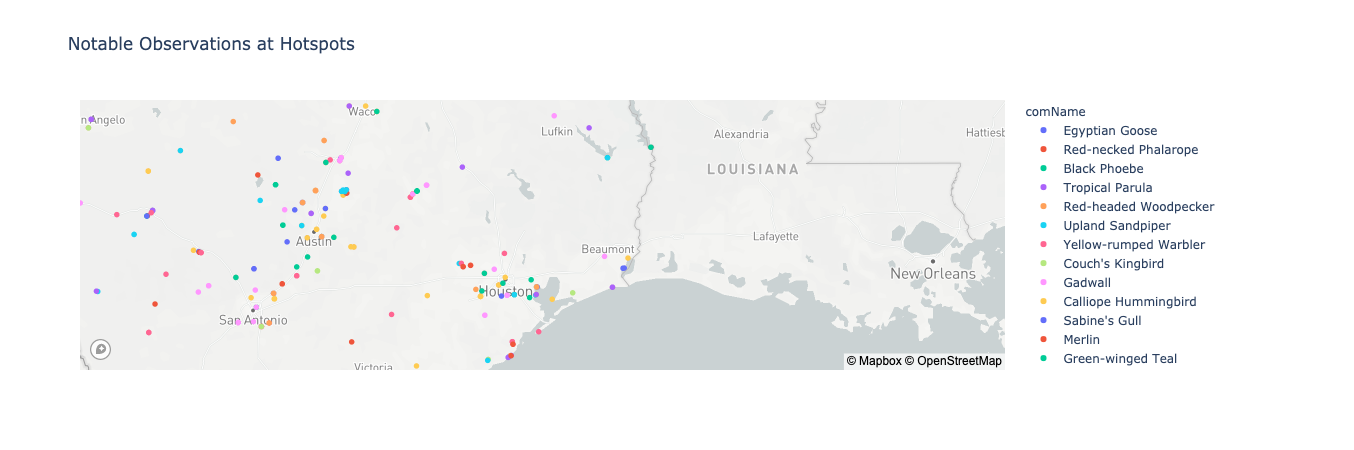

In [31]:
# Map observations with Plotly

fig_hotspots = px.scatter_mapbox(
    df_notables_hotspots,
    lat="lat",
    lon="lng",
    color="comName",
    hover_data=["howMany", "obsDt", "subId"],
    title="Notable Observations at Hotspots",
)
fig_hotspots.show()

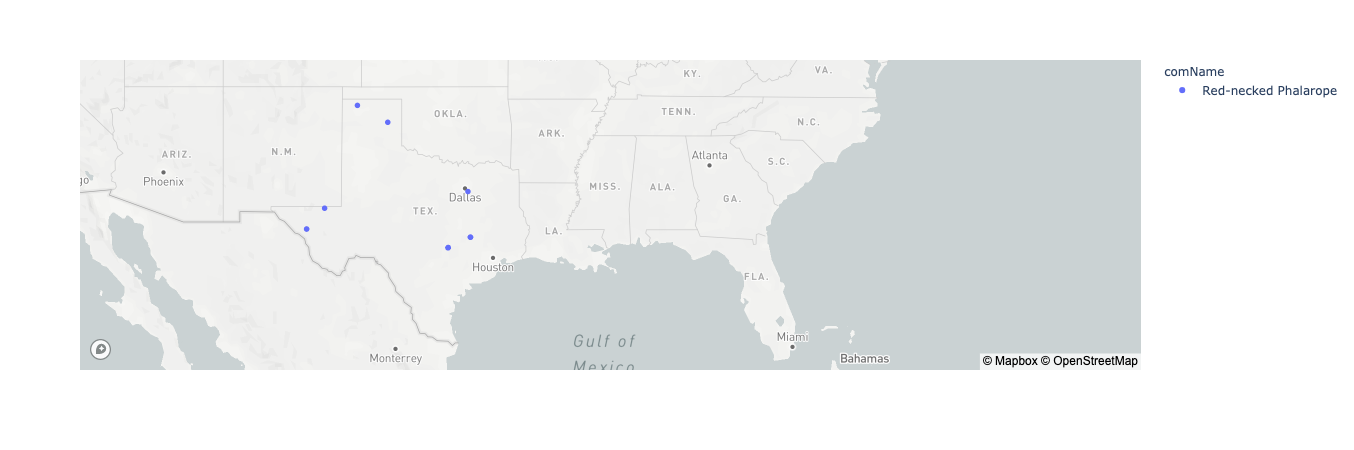

In [30]:
# Maps with plotly
red_necked_phalarope = df_notables.loc[df_notables["comName"] == "Red-necked Phalarope"]
fig_red_necked_phalarope = px.scatter_mapbox(
    red_necked_phalarope,
    lat="lat",
    lon="lng",
    color="comName",
    hover_data=["howMany", "obsDt"],
)
fig_red_necked_phalarope.show()

In [23]:
red_necked_phalarope

speciesCode               comName             sciName      locId  \
2         renpha  Red-necked Phalarope  Phalaropus lobatus    L391467   
35        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
37        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
38        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
39        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
40        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
42        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
44        renpha  Red-necked Phalarope  Phalaropus lobatus   L6225250   
46        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
51        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
52        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
73        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
94        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
95        renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
158       renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
163       renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
204       renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
205       renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
336       renpha  Red-necked Phalarope  Phalaropus lobatus   L1761247   
944       renpha  Red-necked Phalarope  Phalaropus lobatus  L12270499   
1007      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1019      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1024      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1028      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1034      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1037      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1038      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1055      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1058      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1063      renpha  Red-necked Phalarope  Phalaropus lobatus    L130766   
1246      renpha  Red-necked Phalarope  Phalaropus lobatus   L1404227   
1629      renpha  Red-necked Phalarope  Phalaropus lobatus  L12218067   
1630      renpha  Red-necked Phalarope  Phalaropus lobatus  L12218067   

                                               locName             obsDt  \
2                                 Dallas Southside WTP  2020-09-24 11:24   
35              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:40   
37              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:40   
38              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:40   
39              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:40   
40              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:40   
42              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:10   
44              Brazos Co.--Sims Lane/Sims Lane Cutoff  2020-09-23 19:00   
46                             Hornsby Bend (HOTE 037)  2020-09-23 18:30   
51                             Hornsby Bend (HOTE 037)  2020-09-23 17:49   
52                             Hornsby Bend (HOTE 037)  2020-09-23 17:49   
73                             Hornsby Bend (HOTE 037)  2020-09-23 13:01   
94                             Hornsby Bend (HOTE 037)  2020-09-23 09:25   
95                             Hornsby Bend (HOTE 037)  2020-09-23 09:25   
158                            Hornsby Bend (HOTE 037)  2020-09-22 14:05   
163                            Hornsby Bend (HOTE 037)  2020-09-22 12:00   
204                            Hornsby Bend (HOTE 037)  2020-09-21 15:10   
205                            Hornsby Bend (HOTE 037)  2020-09-21 15:10   
336                   Red Bluff Reservoir (Loving Co.)  2020-09-19 15:03   
94

#### Note: some observations are nearly duplicates (same lat/long and other details) but have slightly different observation times and are recorded with separate subId's.

In [24]:
name_count = df_notables["comName"].value_counts()
name_count

Calliope Hummingbird     64
Rufous Hummingbird       62
Least Grebe              52
Brown Pelican            46
Snowy Plover             44
                         ..
Dunlin                    1
Gray Vireo                1
Curve-billed Thrasher     1
Canyon Wren               1
Rock Wren                 1
Name: comName, Length: 320, dtype: int64

In [27]:
names = df_notables["comName"].unique()

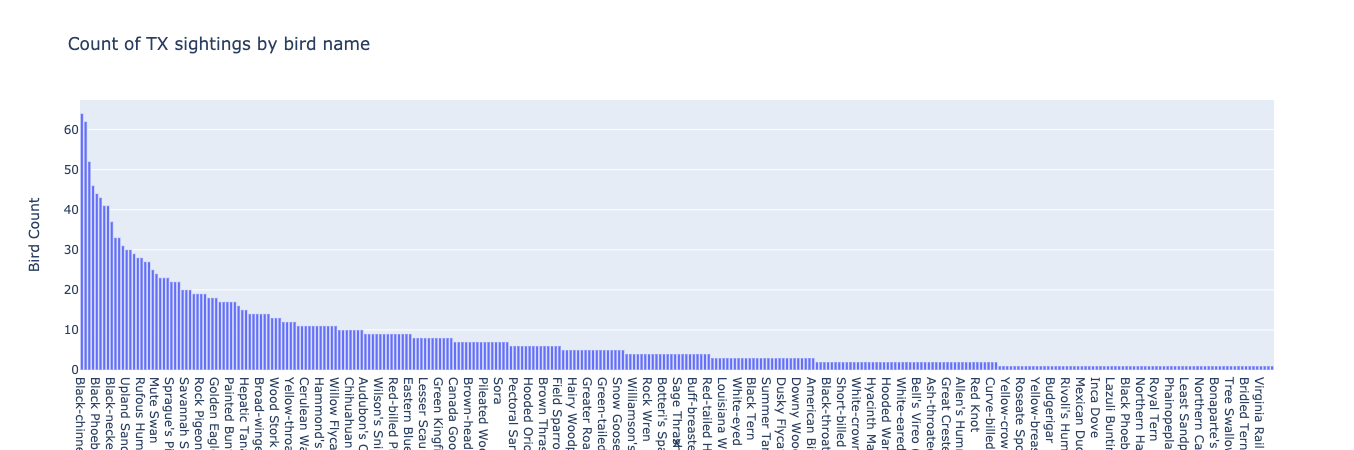

In [58]:
px.bar(
    x=names,
    y=name_count,
    title="Count of TX sightings by bird name",  # add Title and Labels
    labels={"y": "Bird Count"},
)  # next, try a bar chart of top 10 or 50. do the same for least observed?

# What makes these observations notable?

 Notable observations can be for locally or nationally rare species or are otherwise unusual, e.g. over-wintering birds in a 
 species which is normally only a summer visitor. (eBird API documentation)

# Issues to work:

MORE THOUGHTS:
* can keep going... merge the city name back into the new dataframe
* use request to get open weather map data for the cities (if possible going back 7 days ... may need a different weather API to see past weather data)
* could compare number of observations to temp / weather type (sunny, windy, rainy)
* use Google geocoding API to map cities to lat/lon and put number of sightings on map using plotly
* make a bar chart to show which species observed most often across the state
* probably need to actually store the results as they are requested instead of just extracting out individual pieces of info
* eBirds also has "notable" observations request which returns rare birds or unusual observations - could be fun to request a list of "notable" sightings for Austin for * the last X days
* needs to be more robust generally, but this is the skeleton of the idea

1. DAVID - Notable birds in region - try Texas or Austin (Houston!!) -- pick a few wildlife refuges / on the coast / national seashore / etc

In [49]:
regionCodeUS = "US"
url_notables_US = (
    "https://api.ebird.org/v2/data/obs/"
    + regionCodeUS
    + "/recent/notable?back=7"  # max number of days back for observations = 30
)

r_notables_US = requests.get(url_notables_US, params={"key": api_key})

In [50]:
r_notables_US.status_code

200

In [51]:
df_notables_US = pd.DataFrame(r_notables_US.json())
df_notables_US

speciesCode                 comName                 sciName      locId  \
0         amgplo  American Golden-Plover      Pluvialis dominica    L201202   
1         commer        Common Merganser        Mergus merganser  L11866720   
2         pinsis             Pine Siskin            Spinus pinus   L5688037   
3         amgplo  American Golden-Plover      Pluvialis dominica  L12358195   
4         commer        Common Merganser        Mergus merganser  L11866996   
...          ...                     ...                     ...        ...   
9995      rusbla         Rusty Blackbird      Euphagus carolinus   L1499732   
9996      bkbplo    Black-bellied Plover    Pluvialis squatarola    L907119   
9997      whtspa  White-throated Sparrow  Zonotrichia albicollis    L958993   
9998      conwar     Connecticut Warbler        Oporornis agilis    L958993   
9999      gycthr     Gray-cheeked Thrush        Catharus minimus    L989562   

                                                locName             obsDt  \
0                                  Allen Brothers Marsh  2020-09-24 14:51   
1             Ohio River Islands NWR--Williamson Island  2020-09-24 14:47   
2                                      Pilling Lake Bed  2020-09-24 14:38   
3     Assateague Channel, Chincoteague US-VA (37.914...  2020-09-24 14:33   
4         Ohio River Islands NWR--Witten Towhead Island  2020-09-24 14:28   
...                                                 ...               ...   
9995                                  Oak Top (Private)  2020-09-20 06:09   
9996           Silvio O. Conte NWR--Fort River Division  2020-09-20 06:07   
9997                               State Game Lands 220  2020-09-20 06:07   
9998                               State Game Lands 220  2020-09-20 06:07   
9999                        UMass Amherst--Orchard Hill  2020-09-20 06:07   

      howMany        lat        lng  obsValid  obsReviewed  locationPrivate  \
0         1.0  43.095924 -72.447501     False        False            False   
1        14.0  39.594494 -80.956042     False        False            False   
2         1.0  39.800685 -74.981046     False        False            False   
3         1.0  37.914582 -75.364359     False        False             True   
4        25.0  39.585619 -80.971908     False        False            False   
...       ...        ...        ...       ...          ...              ...   
9995      1.0  41.854783 -71.177657      True         True            False   
9996      1.0  42.339625 -72.559826      True         True            False   
9997      1.0  40.272871 -76.119794     False        False            False   
9998      2.0  40.272871 -76.119794     False        False            False   
9999      1.0  42.394527 -72.520795      True         True            False   

          subId  
0     S74005595  
1     S74005537  
2     S74005208  
3     S74005652  
4     S74004624  
...         ...  
9995  S73831598  
9996  S73816326  
9997  S73821752  
9998  S73821752  
9999  S73816824  

[10000 rows x 13 columns]

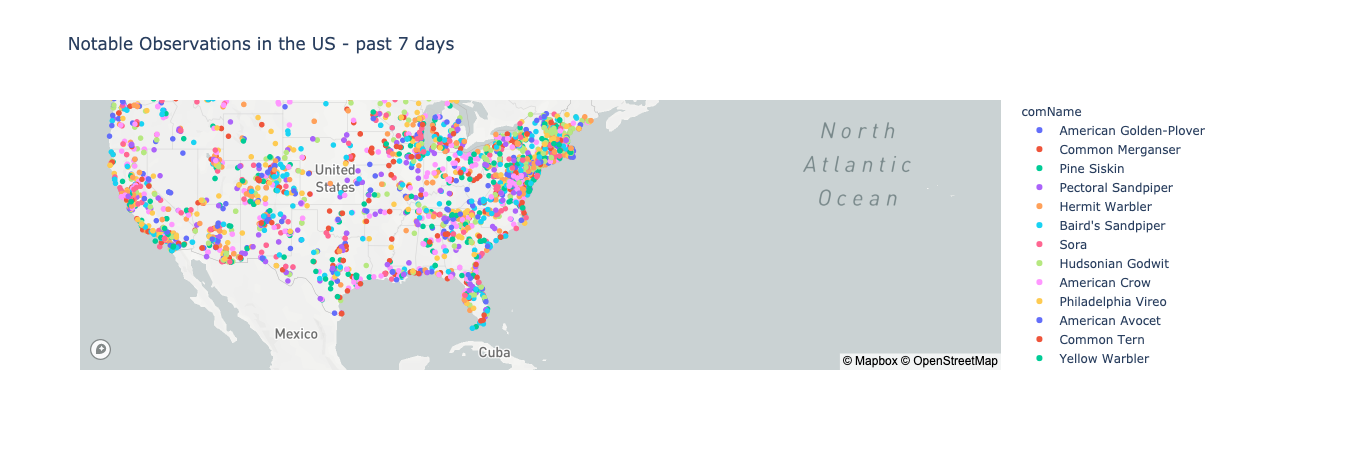

In [52]:
fig_US = px.scatter_mapbox(
    df_notables_US,
    lat="lat",
    lon="lng",
    color="comName",
    hover_data=["howMany", "obsDt", "subId"],
    title="Notable Observations in the US - past 7 days",
)
fig_US.show()

# Try a bar chart of top 10 or 50. do the same for least observed?

In [55]:
names_US = df_notables_US["comName"].unique()
name_count_US = df_notables_US["comName"].value_counts()

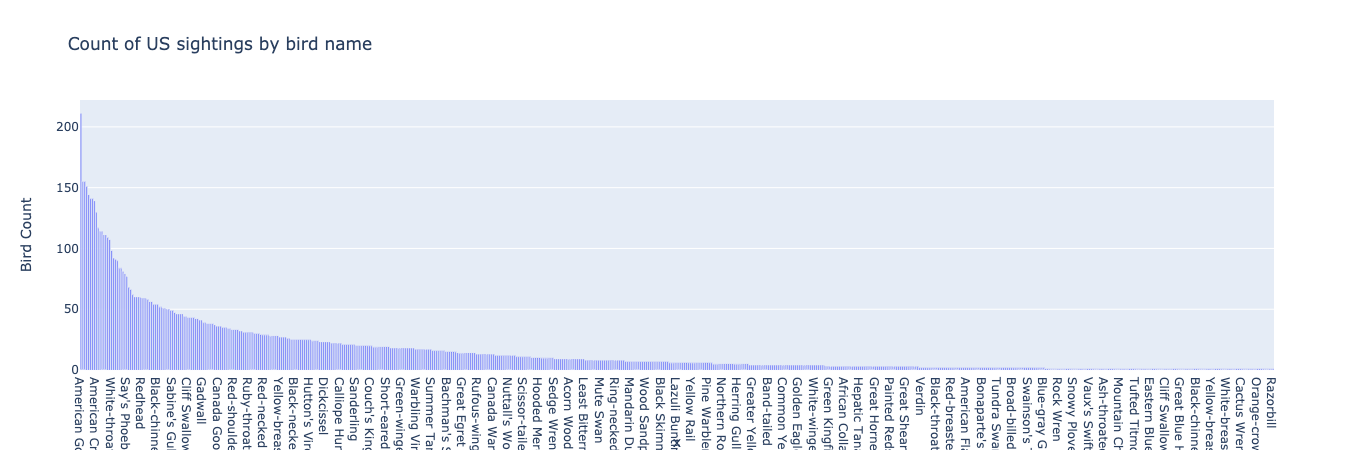

In [59]:
px.bar(
    x=names_US,
    y=name_count_US,
    title="Count of US sightings by bird name",  # add Title and Labels
    labels={"y": "Bird Count"},
)

## TEST